In [1]:
%%time
from __future__ import absolute_import, division, unicode_literals, print_function
%reload_ext autoreload
%autoreload 2
%load_ext tensorboard

import cv2
from PIL import Image
import scipy
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(rc={"figure.figsize":(12,10)})
sns.set_style("whitegrid")
%matplotlib inline

import gc
gc.enable()
import os
import sys
import math
import csv
import json
import random
import datetime
import subprocess
from multiprocessing import Pool
from tqdm import tqdm_notebook, tqdm

print("Supressing warnings..")
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
print("Warnings supressed.")

try:
  %tensorflow_version 2.x
  print("TensorFlow 2.0 rc is live and running.")
except:
  print("Cant load TensorFlow 2.0 rc")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import plot_model

print("TensorFlow version: ",tf.__version__)
print("Eager execution: ", tf.executing_eagerly())
print("GPU is", "available." if tf.test.is_gpu_available() else "unavailable.")
print("Seeding...")
def seedall(seed):
  try:
    np.random.seed(seed)
    random.seed(seed)
    tf.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = seed
    print("Random Seeds have been initialized")
  except:
    print("Couldn't initialize the random seed.")

seedall(999)

from IPython.display import display, clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print("Done.!")

Supressing warnings..
Warnings supressed.
TensorFlow 2.x selected.
TensorFlow 2.0 rc is live and running.
TensorFlow version:  2.0.0-rc0
Eager execution:  True
GPU is unavailable.
Seeding...
Couldn't initialize the random seed.
Done.!
CPU times: user 2.3 s, sys: 519 ms, total: 2.82 s
Wall time: 8.59 s


In [0]:
!pip install -q pyyaml h5py

In [50]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_labels = train_labels[:50000]
test_labels = test_labels[:10000]

train_images = train_images[:50000].reshape(-1, 28*28)/255.0
test_images = test_images[:10000].reshape(-1, 28*28)/255.0

print(train_images.shape)
print(test_images.shape)

(50000, 784)
(10000, 784)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               200960    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

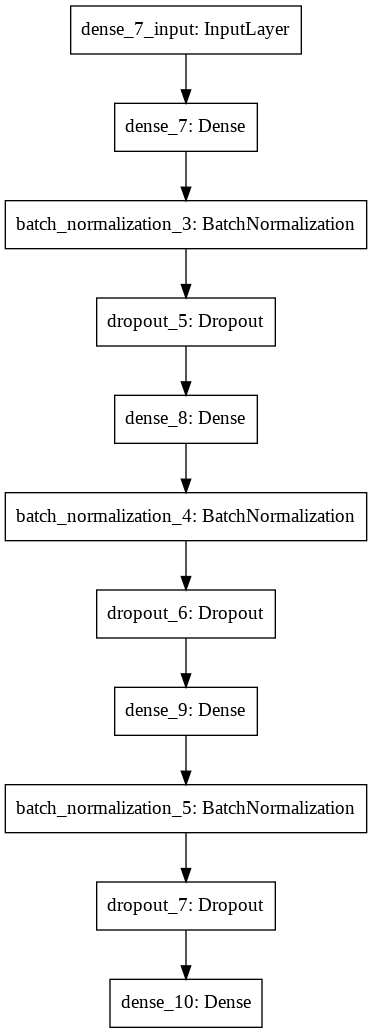

In [51]:
def create_model():
  model = tf.keras.Sequential([
                               layers.Dense(256, activation=tf.nn.relu, input_shape=((784,)),kernel_initializer="he_uniform",kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                               layers.BatchNormalization(),
                               layers.Dropout(0.2),
                               layers.Dense(128,activation=tf.nn.relu,kernel_initializer="he_uniform",kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                               layers.BatchNormalization(),
                               layers.Dropout(0.2),
                               layers.Dense(64,activation=tf.nn.relu,kernel_initializer="he_uniform",kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                               layers.BatchNormalization(),
                               layers.Dropout(0.2),
                               layers.Dense(10, activation="softmax")
  ])
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["accuracy","sparse_categorical_crossentropy"])
  return model

model =  create_model()

model.summary()

plot_model(model)

In [0]:
import json

In [0]:
class PlotLearning(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.loss = []
    self.val_loss = []
    self.acc = []
    self.val_acc = []
    self.fig = plt.figure()
    self.logs = []
    # self.scc = []
    # self.val_scc = []

  def on_epoch_end(self, epoch, logs={}):
      
    self.logs.append(logs)
    self.x.append(self.i)
    self.loss.append(logs.get('loss'))
    self.acc.append(logs.get('accuracy'))
    #self.scc.append(logs.get('sparse_categorical_crossentropy'))
    self.val_loss.append(logs.get('val_loss'))        
    self.val_acc.append(logs.get('val_accuracy'))
    #self.val_acc.append(logs.get('val_sparse_categorical_crossentropy'))
    self.i += 1
    f, ax = plt.subplots(1, 2, figsize=(18,6), sharex=True)
    ax = ax.flatten()
    clear_output(wait=True)
    
    ax[0].plot(self.x, self.loss, label="loss", lw=2)
    ax[0].plot(self.x, self.val_loss, label="val loss")
    #ax[0].set_ylim(bottom=0.)
    ax[0].legend()
    ax[0].grid(True)
      
    ax[1].plot(self.x, self.acc, label="Accuracy", lw=2)
    ax[1].plot(self.x, self.val_acc, label="val Accuracy")
    #ax[1].set_ylim(bottom=0.)
    ax[1].legend()
    ax[1].grid(True)
    
    # ax[2].plot(self.x, self.scc, label="categorical cross entropy", lw=2)
    # ax[2].plot(self.x, self.val_scc, label="val categorical cross entropy")
    # # #ax[0].set_ylim(bottom=0.)
    # ax[2].legend()
    # ax[2].grid(True)

    plt.show();
        
plotLoss = PlotLearning()

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("model_regressor.h5",monitor="val_loss",verbose=1,save_best_only=True,mode="auto")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.3,patience=3,verbose=1,mode="auto",min_lr=0.000001)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",verbose=1,mode="auto", patience=6)

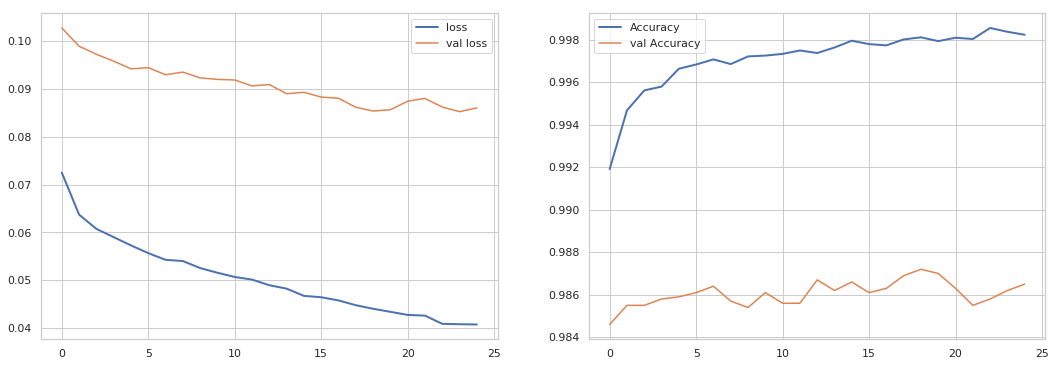

50000/50000 [==============================] - 3s 68us/sample - loss: 0.0408 - accuracy: 0.9982 - sparse_categorical_crossentropy: 0.0063 - val_loss: 0.0861 - val_accuracy: 0.9865 - val_sparse_categorical_crossentropy: 0.0517


In [67]:
#%tensorboard --logdir logs
history = model.fit(train_images, 
                    train_labels,
                    steps_per_epoch=train_images.shape[0]/1024,
                    batch_size=1024, 
                    epochs=25, 
                    verbose=1,
                    validation_data=(test_images,test_labels),
                    callbacks=[tensorboard, checkpoint, reduce_lr,  early_stopping, plotLoss])

In [0]:
# from tensorboard import notebook
# notebook.list()
# notebook.display(port=6006, height=1000)

In [0]:
# !rm -r logs

In [70]:
!ls

logs  model.png  model_regressor.h5  sample_data


In [75]:
model = create_model()
model.summary()
# results= model.evaluate(test_images,test_labels)
# print("Untrained model, accuracy: {5.2f}%".format(100*results))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 256)               200960    
_________________________________________________________________
batch_normalization_18 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_19 (Batc (None, 128)               512       
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)               

In [82]:
model.evaluate(test_images, test_labels)
#print("Untrained model, accuracy: {:5.2f}%".format(100*accuracy))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[3.309030197906494, 0.0878, 2.4134717]

In [0]:
model.load_weights("model_regressor.h5")

In [86]:
model.evaluate(test_images, test_labels)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.08525709710717201, 0.9862, 0.050711583]

In [87]:
#manually save weights
model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
model = create_model()

# Restore the weights
model.load_weights('./checkpoints/my_checkpoint')

# Evaluate the model
loss,acc, bcc = model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
#save entire model 

model.save('my_model.h5')

In [89]:
new_model = keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 256)               200960    
_________________________________________________________________
batch_normalization_21 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_22 (Batc (None, 128)               512       
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)               